In [76]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import itertools


In [77]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [
        ([2], lambda df: isin_filter(df, 'ovar_histtype', [2])), 
        ([2, 4, 6, 8, 9, 31], lambda df: isin_filter(df, 'ovar_histtype', [2, 4, 6, 8, 9, 31]))
    ]
}


In [78]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    # ExperimentDataHelperScreenedOrCancer,
    ExperimentDataHelperScreened,
    ExperimentDataHelperNotScreenedCols,
    ExperimentDataHelperScreenedCols,
    ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    # ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll
]

In [79]:
experiment_names = []
years = [1]
num_folds=10
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            label = f'cancer_in_next_{year}_years'
            filesuffix = f'experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_for_{label}_{num_folds}_trials'
            experiment_names.append(filesuffix)

In [80]:
experiment_names

['experiment_participants_screened_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_participants_all_XGBClassifier_for_cancer_in_next_1_years_10_trials']

In [81]:
def load_cv_analytics_util_see_stats(filesuffix):
    cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    return cv_analytics_util

In [82]:
filesuffix = 'experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials'



Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999335   | 0.000149559 | 0.999073   | 0.99957    |
| recall__class_0    | 0.874615   | 0.00613486  | 0.861479   | 0.886032   |
| f1-score__class_0  | 0.932814   | 0.00349794  | 0.925282   | 0.93926    |
| precision__class_1 | 0.00556946 | 0.000489029 | 0.00499319 | 0.00637691 |
| recall__class_1    | 0.550902   | 0.0538129   | 0.484375   | 0.647059   |
| f1-score__class_1  | 0.0110257  | 0.000958087 | 0.00989357 | 0.0126225  |
| accuracy           | 0.874194   | 0.00612838  | 0.86105    | 0.88555    |
| auc                | 0.831947   | 0.0164517   | 0.799297   | 0.856915   |
+--------------------+------------+-------------+------------+------------+


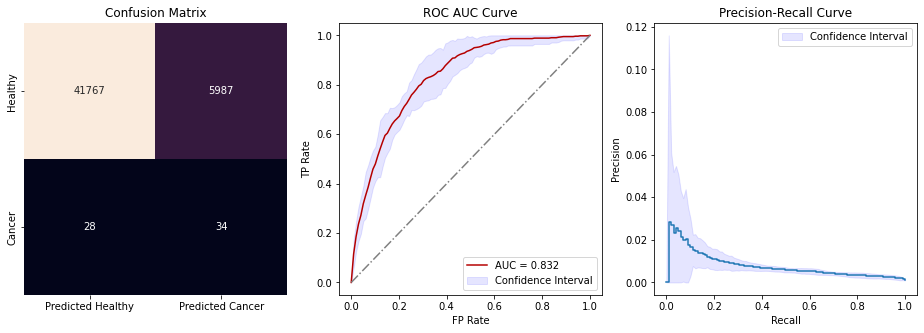

In [83]:

cv_analytics_util = load_cv_analytics_util_see_stats(filesuffix)

In [84]:
cv_analytics_util.analytics_utils[0].data_util.train_df.columns

Index(['plco_id', 'age', 'agelevel', 'arthrit_f', 'asp', 'asppd', 'bbd',
       'bcontr_f', 'bcontra', 'bcontrt',
       ...
       'thorm', 'trypreg', 'tubal', 'tuballig', 'usound_history',
       'uterine_fib', 'was_screened', 'weight20_f', 'weight50_f', 'weight_f'],
      dtype='object', length=108)

In [85]:
threshold = 0.1611

In [86]:
all_mid_confidence_ids = []
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch = analytics_util.data_util.test_df.copy()[['plco_id', 'age', label]]
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    # X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > threshold) & (X_test_mismatch[f'{label}_prob'] < 1 - threshold)]
    # X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > 0.5)]
    id_and_confidence.append(X_test_high_conf)
    mid_conf_ids = X_test_high_conf['plco_id'].to_list()
    all_mid_confidence_ids.extend(mid_conf_ids)
mid_conf_predictions = pd.concat(id_and_confidence)

In [87]:
len(all_mid_confidence_ids)

137963

In [88]:
filesuffix = 'experiment_participants_screened_XGBClassifier_for_cancer_in_next_1_years_10_trials'
cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)

In [89]:
full_df = []

In [90]:
for analytics_util in cv_analytics_util.analytics_utils:
    full_df.append(analytics_util.data_util.test_df)
full_df = pd.concat(full_df)

In [91]:
full_df = full_df[full_df['plco_id'].isin(all_mid_confidence_ids)].drop_duplicates()

In [92]:
len(full_df)

134693

In [93]:
# for analytics_util in cv_analytics_util.analytics_utils:
#     # analytics_util.data_util.test_df = full_df
#     analytics_util.data_util.test_df = analytics_util.data_util.test_df[analytics_util.data_util.test_df['plco_id'].isin(all_mid_confidence_ids)]
#     print(len(analytics_util.data_util.test_df))

In [94]:
mid_range_filter = lambda df: isin_filter(df, 'plco_id', all_mid_confidence_ids)

In [95]:
# TODO: compare the confidences
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    y_pred, y_prob = analytics_util.get_predictions_filtered(mid_range_filter) 
    # X_test_mismatch = analytics_util.data_util.test_df.copy()[['plco_id', 'age', label]]
    X_test_mismatch = mid_range_filter(analytics_util.data_util.test_df).copy()
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    id_and_confidence.append(X_test_mismatch)
    mid_conf_ids = X_test_mismatch['plco_id'].to_list()
mid_conf_predictions_2 = pd.concat(id_and_confidence)

In [96]:
# mid_conf_predictions[mid_conf_predictions['plco_id'] == 'A-002879-7']

In [97]:
# print_df(mid_conf_predictions_2[mid_conf_predictions_2['plco_id'] == 'A-002879-7'])

In [98]:
confidence_comp = mid_conf_predictions_2.merge(mid_conf_predictions, on=['plco_id', 'age'], how='left', suffixes=['_2', '_1'])

In [99]:
# print_df(confidence_comp[confidence_comp['plco_id'] == 'A-002879-7'])

In [100]:
# confidence_comp[confidence_comp['cancer_in_next_1_years_prob_1'].isnull()]



Cross-Validation measures:
+--------------------+-----------+------------+------------+-----------+
|                    |      mean |        std |        min |       max |
|--------------------+-----------+------------+------------+-----------|
| precision__class_0 | 0.999258  | 0.00019871 | 0.998934   | 0.999528  |
| recall__class_0    | 0.960791  | 0.00378325 | 0.955391   | 0.967064  |
| f1-score__class_0  | 0.979643  | 0.00193639 | 0.976865   | 0.982916  |
| precision__class_1 | 0.0103993 | 0.00287573 | 0.00623053 | 0.0162272 |
| recall__class_1    | 0.368658  | 0.086734   | 0.228571   | 0.482759  |
| f1-score__class_1  | 0.0201984 | 0.00548085 | 0.0121827  | 0.0310982 |
| accuracy           | 0.960122  | 0.00371655 | 0.954793   | 0.966415  |
| auc                | 0.859516  | 0.0367265  | 0.781926   | 0.899042  |
+--------------------+-----------+------------+------------+-----------+


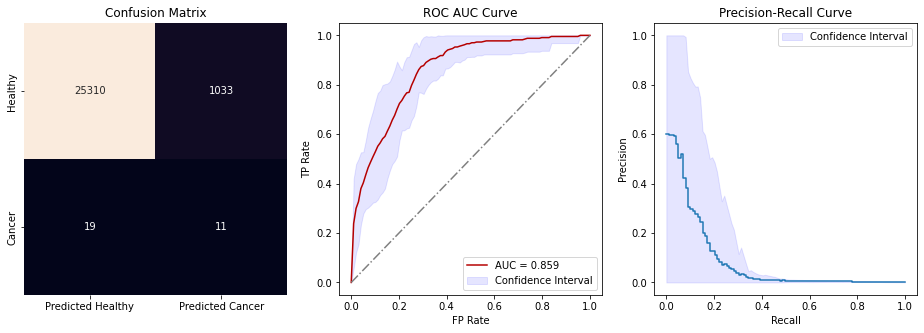

In [101]:
cv_analytics_util.get_cv_report();
cv_analytics_util.display_graph()

In [102]:
# thresholds = []
# for analytics_util in cv_analytics_util.analytics_utils:
#     thresholds.append(analytics_util.get_report_generation_util().get_roc_threshold())

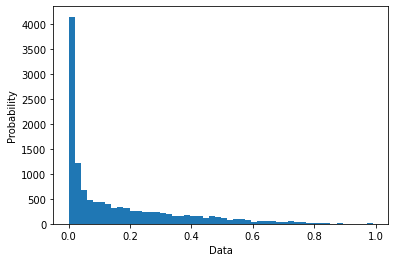

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(X_test_mismatch[f'{label}_prob'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');



In [104]:
# for filesuffix in experiment_names:
#     print(filesuffix)
#     load_cv_analytics_util_see_stats(filesuffix)